In [ ]:
# Step 1: Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

# Step 2: Restart the runtime after this step, then run the next cell:
import sys, os
sys.path.append('/usr/local/lib/python3.10/site-packages')


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 5.41 MiB/s, done.
Resolving deltas: 100% (299/299), done.
PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We have also created a new startup template: 
https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9?usp=sharing

CHANGES T
CELL 1:
    # This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("/content/drive/MyDrive/yellow_tripdata.csv", header=None, low_memory=False)

In [ ]:
# Confirm cuML is working
import cuml
import cupy as cp
from cuml.cluster import KMeans
print("cuML version:", cuml.__version__)

cuML version: 25.02.01


In [ ]:
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract time features
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday

# Select features for clustering
features = [
    'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'pickup_hour',
    'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'extra', 'pickup_dayofweek',
    'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'
]

In [ ]:
df_cluster = df[features]

In [ ]:
df_cluster.dtypes

,0
0,
passenger_count,object
trip_distance,object
pickup_longitude,object
pickup_latitude,object
pickup_hour,int32
dropoff_longitude,object
dropoff_latitude,object
fare_amount,object
extra,object


In [ ]:
df_int32 = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype('int32')

In [ ]:
import cupy as cp
import cudf
from cuml.cluster import KMeans as cuKMeans
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.model_selection import train_test_split as cu_train_test_split
import time

# Convert to cuDF
gdf = cudf.DataFrame.from_pandas(df_int32)

# Standardize
scaler = cuStandardScaler()
X_gpu = scaler.fit_transform(gdf)

X_train_gpu, X_test_gpu = cu_train_test_split(X_gpu, test_size=0.2, random_state=42)


inertia_gpu = []
for k in range(1, 11):
    kmeans_gpu = cuKMeans(n_clusters=k, random_state=42)
    kmeans_gpu.fit(X_train_gpu)
    inertia_gpu.append(kmeans_gpu.inertia_)



/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


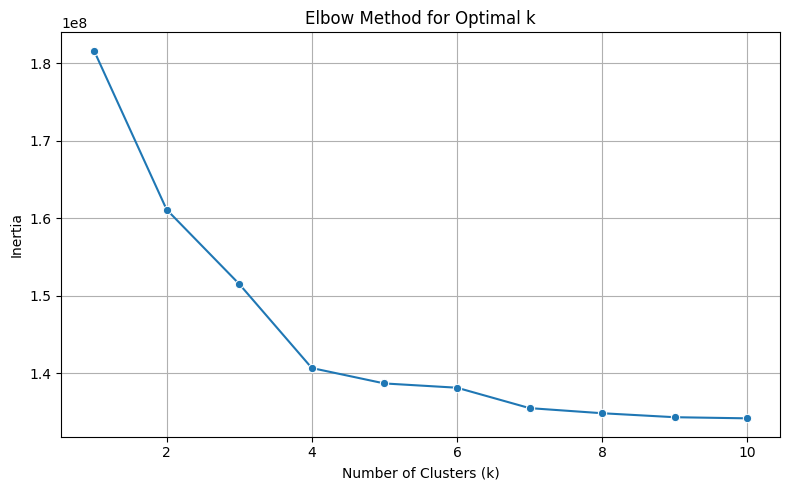

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 11), y=inertia_gpu, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Train KMeans on X_train_gpu
start_train = time.time()

kmeans_gpu = cuKMeans(n_clusters=5, random_state=42)
kmeans_gpu.fit(X_train_gpu)

end_train = time.time()

train_time = end_train - start_train
print(f"GPU KMeans Training Time: {train_time:.4f} seconds")

GPU KMeans Training Time: 2.7799 seconds


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


In [ ]:
# Predict on X_test_gpu
start_pred = time.time()

y_test_pred_gpu = kmeans_gpu.predict(X_test_gpu)

end_pred = time.time()

pred_time = end_pred - start_pred
print(f"GPU KMeans Prediction Time: {pred_time:.4f} seconds")

GPU KMeans Prediction Time: 0.1129 seconds


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:193: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  ret = func(*args, **kwargs)


In [ ]:
import cupy as cp
def print_memory_usage_gb():
  device = cp.cuda.Device(0)
  free_mem, total_mem = device.mem_info
  free_mem /= (1024 ** 3)
  total_mem /= (1024 ** 3)
  used_mem = total_mem - free_mem
  print(f"GPU VRAM Usage: {used_mem:.4f} GB out of {total_mem:.4f} GB")

print_memory_usage_gb()

GPU VRAM Usage: 7.1161 GB out of 14.7413 GB
